# Práctica 1
Miriam Méndez y Laura Lasso

Andrea Mayor

## 1 Importación de librerías y carga de datos

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import torchvision
import torchvision.utils as vutils
from torchvision.transforms import RandomHorizontalFlip, RandomRotation

import matplotlib.pyplot as plt
import numpy as np
import os


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, random_split

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
print(torch.cuda.is_available())
#print(torch.cuda.get_device_name(0))

True


In [ ]:
DATASET = os.path.join('/content/drive/My Drive/AA2/datasets', 'data') # esto puede cambiar dependiendo de donde se ejecute el notebook
INITIAL_SIZE_OF_IMAGES = (128, 128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize(INITIAL_SIZE_OF_IMAGES),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=DATASET, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

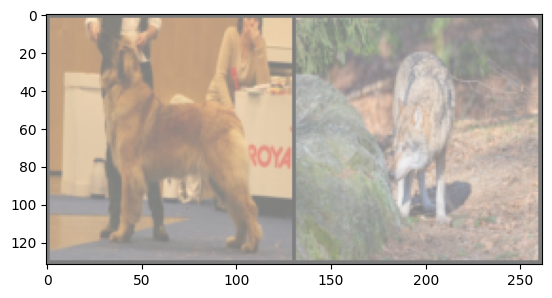

In [ ]:
# Obtiene un batch de imagenes
dataiter = iter(train_loader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Mostramos las imagenes
imshow(vutils.make_grid(images[1:3], normalize=True))


In [ ]:
train_size = int(0.7 * len(train_dataset))  # 70% para entrenamiento
remaining = len(train_dataset) - train_size
val_size = int(0.5 * remaining)  # 15% para validación
test_size = remaining - val_size  # 15% para prueba

train_data, remaining_data = random_split(train_dataset, [train_size, remaining])
val_data, test_data = random_split(remaining_data, [val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
print(len(test_loader))

10


## 2 Redes convolucionales

### 2.1 Primera red convolucional: AdvancedCNN

In [17]:
class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()
        self.features = nn.Sequential(
            # Capa convolucional 1
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Capa convolucional 2
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Capa convolucional 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * (INITIAL_SIZE_OF_IMAGES[0]//8) * (INITIAL_SIZE_OF_IMAGES[1]//8), 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 2),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Aplanar para la clasificación
        x = self.classifier(x)
        return x

### 2.2 Segunda red convolucional: ImprovedCNN

In [18]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 2),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

### 2.3 Definición de las funciones para aplicar en el entrenamiento

In [ ]:
def load_data():
    train_dataset = datasets.ImageFolder(root=DATASET, transform=data_transforms)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    train_size = int(0.7 * len(train_dataset))  # 70% para entrenamiento
    remaining = len(train_dataset) - train_size
    val_size = int(0.5 * remaining)  # 15% para validación
    test_size = remaining - val_size  # 15% para prueba

    train_data, remaining_data = random_split(train_dataset, [train_size, remaining])
    val_data, test_data = random_split(remaining_data, [val_size, test_size])

    # DataLoaders
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    # print(len(test_loader))
    return train_data, train_loader, val_loader, test_loader, val_data

def calculate_accuracy(model, data_loader):
    model.eval()  # Poner el modelo en modo evaluación
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Función para entrenar el modelo
def train_model(model, train_loader, val_loader=None, num_epochs=10, l1_lambda=0.0, l2_lambda=0.0, optimizer_type='adam'):
    criterion = nn.CrossEntropyLoss()

    # Añadir regularización L2 al optimizador
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=l2_lambda)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=l2_lambda)
    elif optimizer_type == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9, weight_decay=l2_lambda)
    elif optimizer_type == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=0.01, weight_decay=l2_lambda)
    else:
        raise ValueError(f"Optimizador no reconocido: {optimizer_type}")
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    best_val_acc = 0.0
    early_stopping_counter = 0
    patience = 5
    best_model_wts = None

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Poner el modelo en modo de entrenamiento
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_acc = calculate_accuracy(model, train_loader)
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Training Accuracy: {train_acc}%")

        train_losses.append(running_loss/len(train_loader))
        train_accuracies.append(train_acc)

        # Si tenemos un val_loader, calcular la precisión de validación
        if val_loader is not None:
            val_acc = calculate_accuracy(model, val_loader)
            print(f"Validation Accuracy: {val_acc}%")

            val_losses.append(loss)
            val_accuracies.append(val_acc)

            # Early stopping y guardar el mejor modelo
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                early_stopping_counter = 0
                best_model_wts = model.state_dict().copy()  # Guardar los mejores pesos del modelo
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= patience:
                    print("Early stopping triggered")
                    break

        scheduler.step()

    # Si se encontró un mejor conjunto de pesos, cargarlos
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accuracies, val_accuracies

# Función para evaluar el ensemble en el conjunto de prueba
def evaluate_ensemble(models, data_loader):
    # Colocamos todos los modelos en modo de evaluación
    for model in models:
        model.eval()

    total_predictions = torch.tensor([]).to(device)
    total_true_labels = torch.tensor([]).to(device)

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Obtenemos las predicciones de todos los modelos
            predictions = [model(inputs) for model in models]
            # Calculamos el promedio de las predicciones
            avg_predictions = torch.mean(torch.stack(predictions), dim=0)
            _, ensemble_predicted = torch.max(avg_predictions, 1)

            # Acumulamos las predicciones y las verdaderas etiquetas
            total_predictions = torch.cat((total_predictions, ensemble_predicted))
            total_true_labels = torch.cat((total_true_labels, labels))

    # Calculamos la precisión del ensemble
    ensemble_accuracy = accuracy_score(total_true_labels.cpu(), total_predictions.cpu())
    return ensemble_accuracy

def visualize_predictions(model, data_loader, num_images=5):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)

    # Mostrar imágenes
    imshow(torchvision.utils.make_grid(images[:num_images]))
    images = images.to(device)

    # Obtener predicciones
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Imprimir etiquetas verdaderas y predichas
    print('Etiquetas verdaderas: ', ' '.join(f'{labels[j]}' for j in range(num_images)))
    print('Predicciones: ', ' '.join(f'{predicted[j]}' for j in range(num_images)))

# Matriz de confusión para un modelo específico
def plot_confusion_matrix(model, data_loader, id):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Model {i}')
    plt.show()

# Visualización de la pérdida y precisión
def visualizacion_perdida_precision(train_losses, train_accuracies, settype):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i, train_losses in enumerate(train_losses):
        plt.plot(range(len(train_losses)), train_losses, label=f'Model {i+1} ({settype})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    for i, train_accuracies in enumerate(train_accuracies):
        plt.plot(range(len(train_accuracies)), train_accuracies, label=f'Model {i+1} ({settype})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

def plot_results(train_accuracies, val_accuracies, train_losses, val_losses, model_name, optimizer):

    epochs_range = range(1, len(train_accuracies) + 1)

    # Plot Training and Validation Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy with {model_name} and {optimizer}')
    plt.legend()

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    # Traer los valores de pérdida de vuelta a la CPU antes de graficar
    plt.plot(epochs_range, [val_loss.item() for val_loss in val_losses], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss with {model_name} and {optimizer}')
    plt.legend()

    plt.show()

def accuracy_results(datos):
    # Crear un histograma
    plt.bar(range(len(datos)), datos, color='blue')

    # Agregar etiquetas y título
    plt.xlabel('Modelos')
    plt.ylabel('Accuracies')
    plt.title('Resultados accuracy modelos reentrenados')

### 2.4 Entrenamiento de las redes y visualización de resultados

#### 2.4.1 AdvancedCNN

Training model 1
Epoch 1, Loss: 0.7827183624560182, Training Accuracy: 71.28571428571429%
Validation Accuracy: 70.0%
Epoch 2, Loss: 0.588729284026406, Training Accuracy: 77.85714285714286%
Validation Accuracy: 79.0%
Epoch 3, Loss: 0.540604480965571, Training Accuracy: 74.78571428571429%
Validation Accuracy: 71.66666666666667%
Epoch 4, Loss: 0.47751190106977115, Training Accuracy: 81.85714285714286%
Validation Accuracy: 78.66666666666667%
Epoch 5, Loss: 0.4634264368902553, Training Accuracy: 84.14285714285714%
Validation Accuracy: 77.0%
Epoch 6, Loss: 0.40003237229856575, Training Accuracy: 85.64285714285714%
Validation Accuracy: 76.0%
Epoch 7, Loss: 0.3717480122365735, Training Accuracy: 85.28571428571429%
Validation Accuracy: 73.33333333333333%
Early stopping triggered
Training model 2
Epoch 1, Loss: 0.8166496387936852, Training Accuracy: 73.42857142857143%
Validation Accuracy: 73.33333333333333%
Epoch 2, Loss: 0.572675652124665, Training Accuracy: 79.42857142857143%
Validation Accura

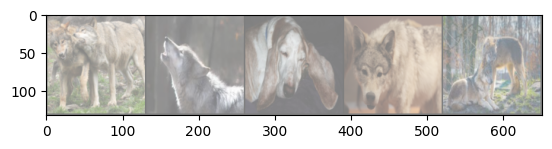

Etiquetas verdaderas:  1 1 0 1 1
Predicciones:  1 1 1 0 1


In [ ]:
torch.manual_seed(0)

# Entrenamiento y validación de modelos individuales
num_models = 3
models = [AdvancedCNN().to(device) for _ in range(num_models)]
best_models = []
train_losses_all = []
val_losses_all = []
train_accuracies_all = []
val_accuracies_all = []

for model_idx, model in enumerate(models):
    print(f"Training model {model_idx+1}")
    best_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, num_epochs=10)

    best_models.append(best_model)
    train_losses_all.append(train_losses)
    val_losses_all.append(val_losses)
    train_accuracies_all.append(train_accuracies)
    val_accuracies_all.append(val_accuracies)

# Reentrenamiento con el conjunto de entrenamiento y validación combinados
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_loader = DataLoader(full_train_data, batch_size=32, shuffle=True)

all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_best_models = []

for model_idx, model in enumerate(best_models):
    print(f"Re-training model {model_idx+1} with full train data")
    model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, full_train_loader, None, num_epochs=5)

    torch.save(model.state_dict(), f'final_model_{model_idx+1}.pth')
    all_best_models.append(model)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

accuracies = []
# Evaluación final de cada modelo en el conjunto de prueba
for model_idx, model in enumerate(best_models):
    model.load_state_dict(torch.load(f'final_model_{model_idx+1}.pth'))
    test_accuracy = calculate_accuracy(model, test_loader)
    accuracies.append(test_accuracy)
    print(f"Final Test Accuracy for model {model_idx+1}: {test_accuracy}%")


# Evaluación final del ensemble en el conjunto de prueba
ensemble_test_accuracy = evaluate_ensemble(best_models, test_loader)
print(f"Ensemble Test Accuracy: {ensemble_test_accuracy}%")

# Llamar a la función con un modelo y un cargador de datos
visualize_predictions(best_models[0], test_loader)

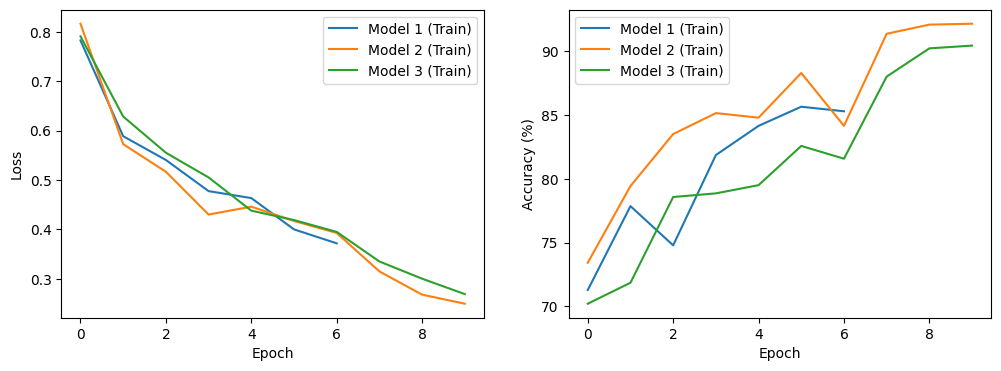

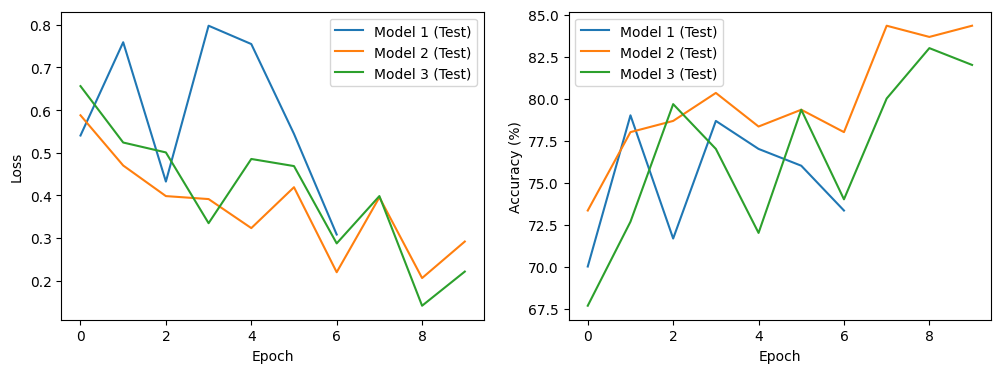

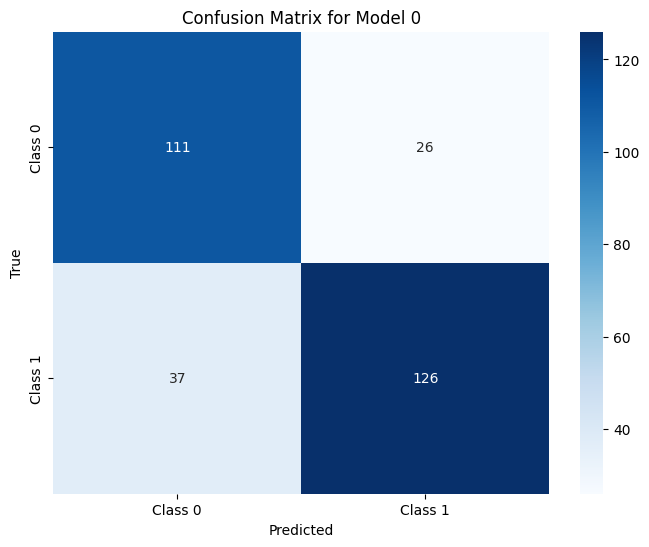

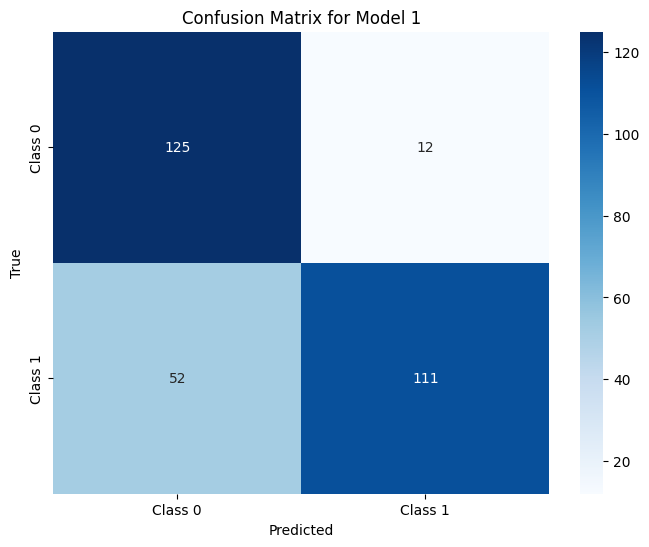

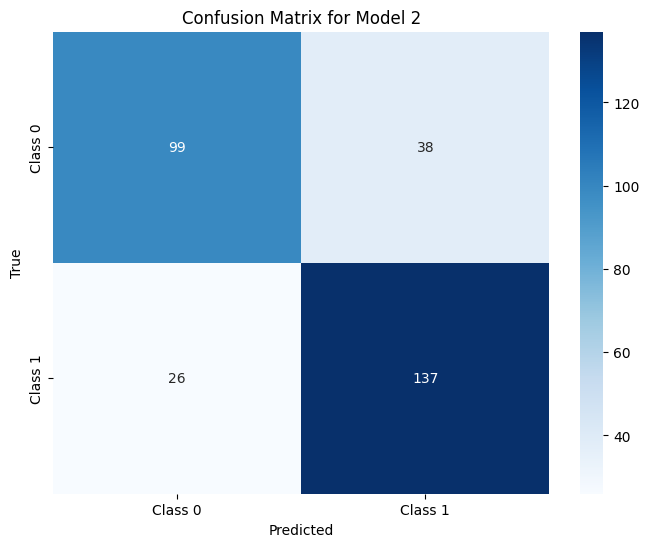

In [ ]:
visualizacion_perdida_precision(train_losses_all, train_accuracies_all, 'Train')
# Suponiendo que val_losses_all y val_accuracies_all son listas de listas con tensores en GPU
val_losses_all_cpu = [[tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in sublist] for sublist in val_losses_all]
val_accuracies_all_cpu = [[tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in sublist] for sublist in val_accuracies_all]

visualizacion_perdida_precision(val_losses_all_cpu, val_accuracies_all_cpu, 'Test')

# Elegir un modelo específico para la matriz de confusión (por ejemplo, el primer modelo)
for i in range(len(best_models)):
  plot_confusion_matrix(best_models[i], test_loader, i)

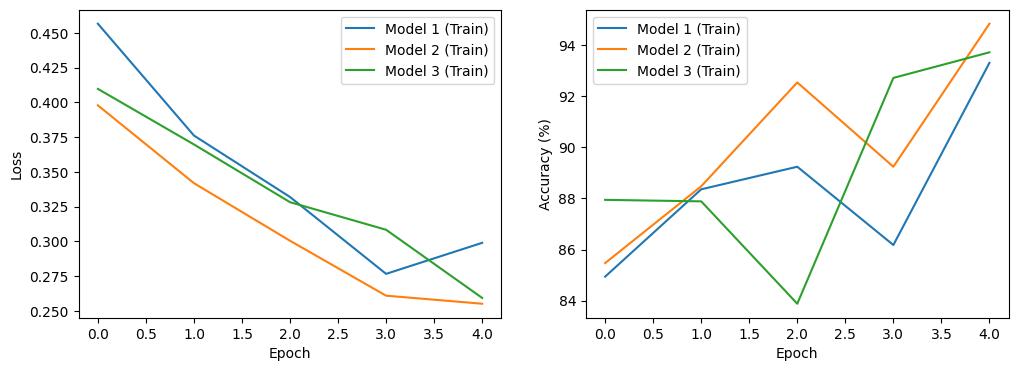

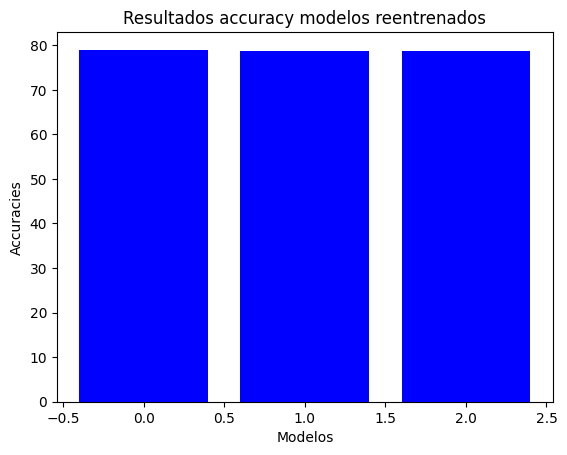

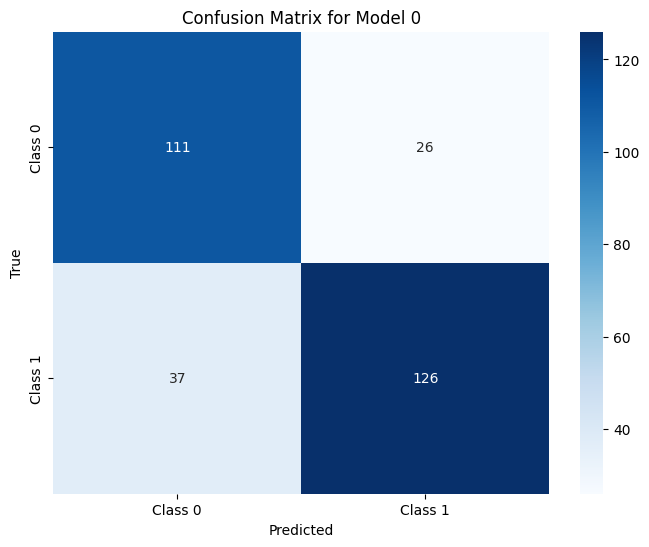

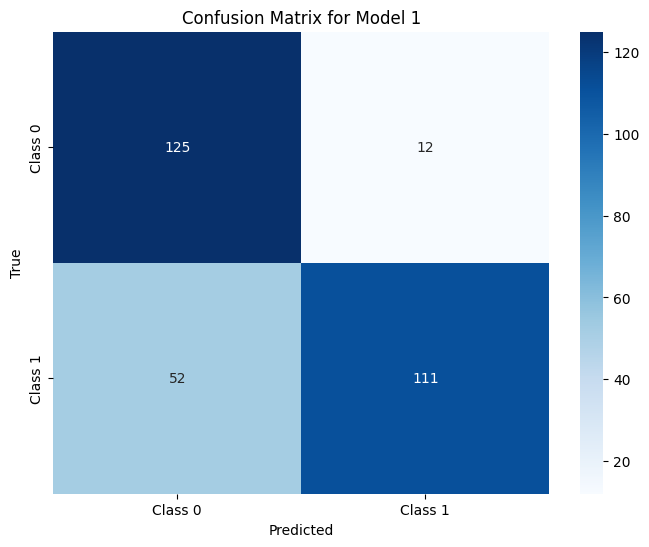

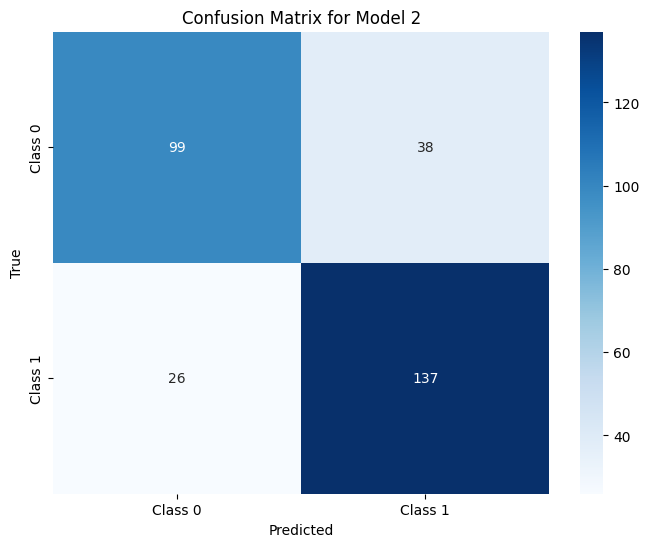

In [ ]:
# resultados modelos reentrenados
visualizacion_perdida_precision(all_train_losses, all_train_accuracies, 'Train')
accuracy_results(accuracies)

# Elegir un modelo específico para la matriz de confusión (por ejemplo, el primer modelo)
for i in range(len(all_best_models)):
  plot_confusion_matrix(all_best_models[i], test_loader, i)

#### 2.4.2 ImprovedCNN

Training model 1
Epoch 1, Loss: 0.6570612950758501, Training Accuracy: 55.285714285714285%
Validation Accuracy: 57.333333333333336%
Epoch 2, Loss: 0.5731519643555988, Training Accuracy: 63.785714285714285%
Validation Accuracy: 64.33333333333333%
Epoch 3, Loss: 0.5354591425169598, Training Accuracy: 76.85714285714286%
Validation Accuracy: 80.33333333333333%
Epoch 4, Loss: 0.5036707710136067, Training Accuracy: 75.71428571428571%
Validation Accuracy: 72.33333333333333%
Epoch 5, Loss: 0.5037759149616415, Training Accuracy: 79.07142857142857%
Validation Accuracy: 77.66666666666667%
Epoch 6, Loss: 0.46523312614722684, Training Accuracy: 79.78571428571429%
Validation Accuracy: 79.66666666666667%
Epoch 7, Loss: 0.45107365162535146, Training Accuracy: 76.28571428571429%
Validation Accuracy: 74.33333333333333%
Epoch 8, Loss: 0.416496735743501, Training Accuracy: 85.71428571428571%
Validation Accuracy: 83.66666666666667%
Epoch 9, Loss: 0.3967888267202811, Training Accuracy: 85.14285714285714%
Va

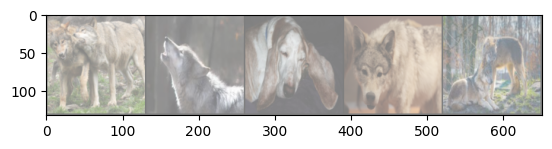

Etiquetas verdaderas:  1 1 0 1 1
Predicciones:  1 0 1 0 1


In [ ]:
torch.manual_seed(0)

num_models = 3
models = [ImprovedCNN().to(device) for _ in range(num_models)]
best_models = []
train_losses_all = []
val_losses_all = []
train_accuracies_all = []
val_accuracies_all = []

for model_idx, model in enumerate(models):
    print(f"Training model {model_idx+1}")
    best_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, num_epochs=10)
    best_models.append(best_model)
    train_losses_all.append(train_losses)
    val_losses_all.append(val_losses)
    train_accuracies_all.append(train_accuracies)
    val_accuracies_all.append(val_accuracies)

full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_loader = DataLoader(full_train_data, batch_size=32, shuffle=True)

all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_best_models = []

for model_idx, model in enumerate(best_models):
    print(f"Re-training model {model_idx+1} with full train data")
    model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, full_train_loader, None, num_epochs=5)
    torch.save(model.state_dict(), f'final_model_{model_idx+1}.pth')
    all_best_models.append(model)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

accuracies = []
for model_idx, model in enumerate(best_models):
    model.load_state_dict(torch.load(f'final_model_{model_idx+1}.pth'))
    test_accuracy = calculate_accuracy(model, test_loader)
    accuracies.append(test_accuracy)
    print(f"Final Test Accuracy for model {model_idx+1}: {test_accuracy}%")

ensemble_test_accuracy = evaluate_ensemble(best_models, test_loader)
print(f"Ensemble Test Accuracy: {ensemble_test_accuracy}%")

visualize_predictions(best_models[0], test_loader)

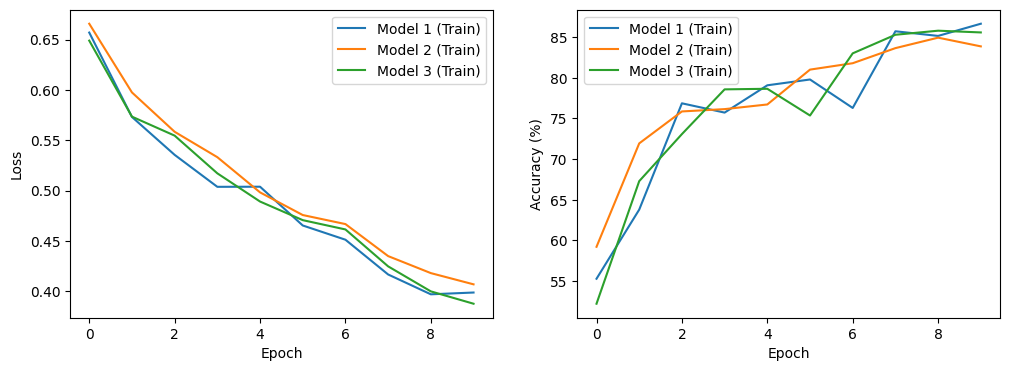

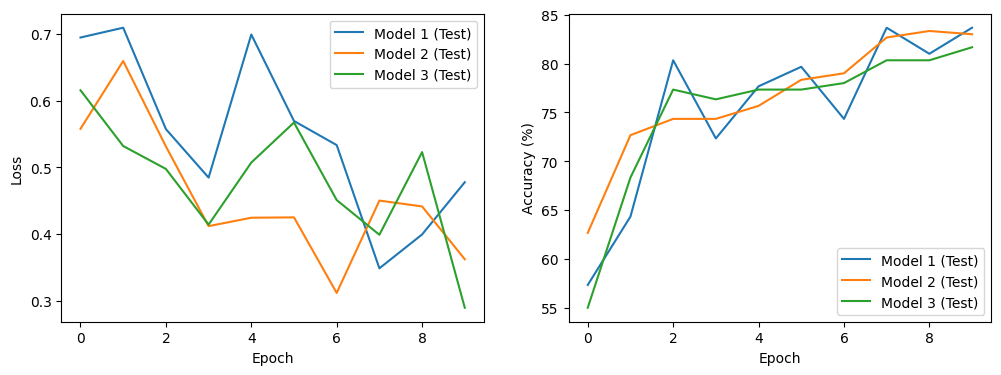

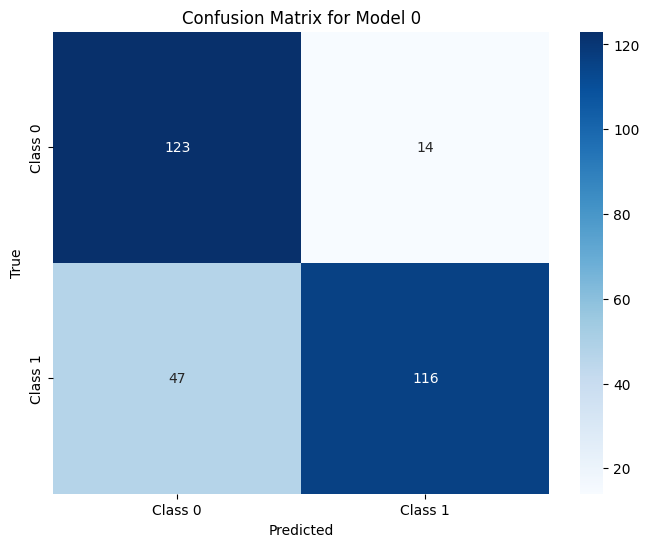

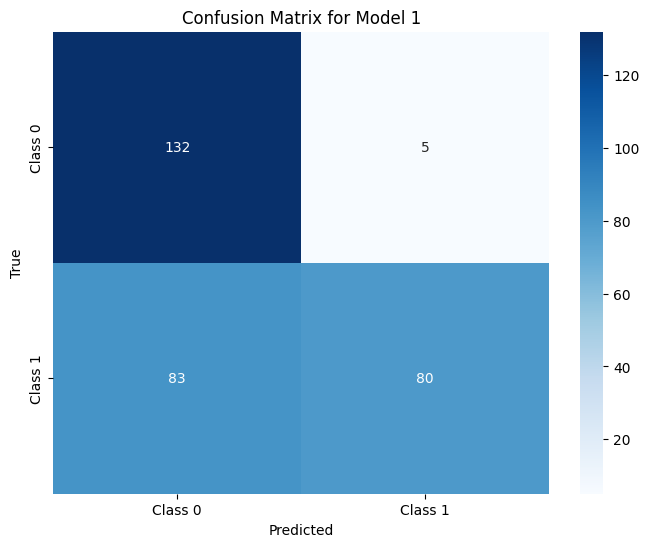

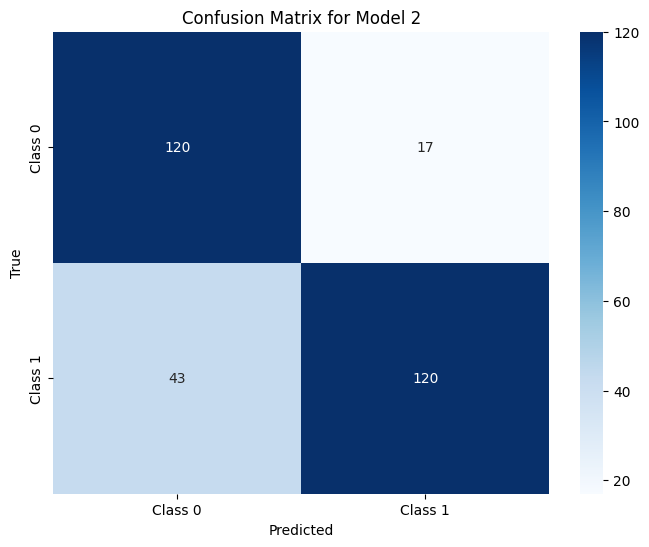

In [ ]:
visualizacion_perdida_precision(train_losses_all, train_accuracies_all, 'Train')
# Suponiendo que val_losses_all y val_accuracies_all son listas de listas con tensores en GPU
val_losses_all_cpu = [[tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in sublist] for sublist in val_losses_all]
val_accuracies_all_cpu = [[tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in sublist] for sublist in val_accuracies_all]

visualizacion_perdida_precision(val_losses_all_cpu, val_accuracies_all_cpu, 'Test')

# Elegir un modelo específico para la matriz de confusión (por ejemplo, el primer modelo)
for i in range(len(best_models)):
  plot_confusion_matrix(best_models[i], test_loader, i)

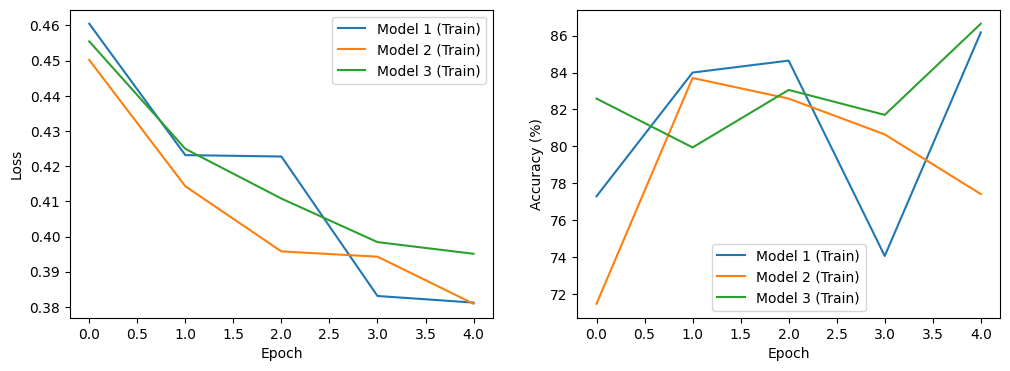

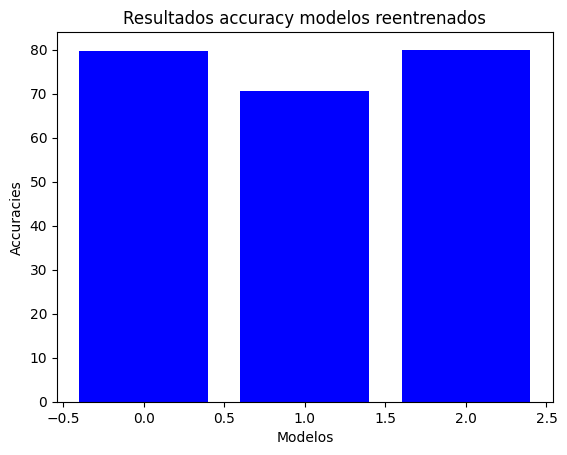

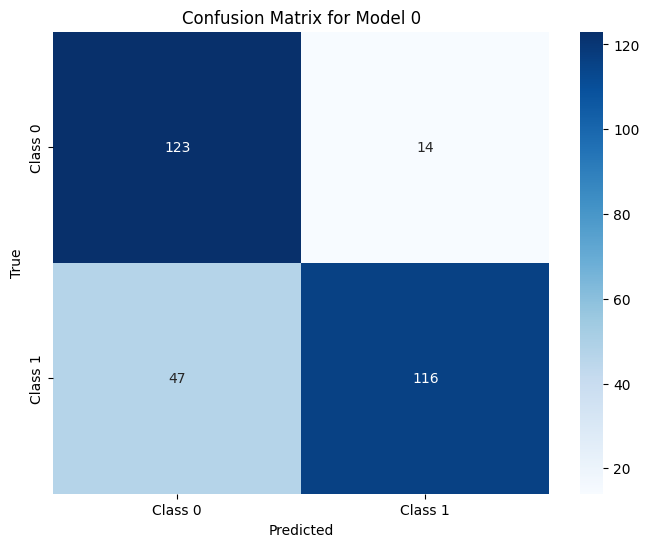

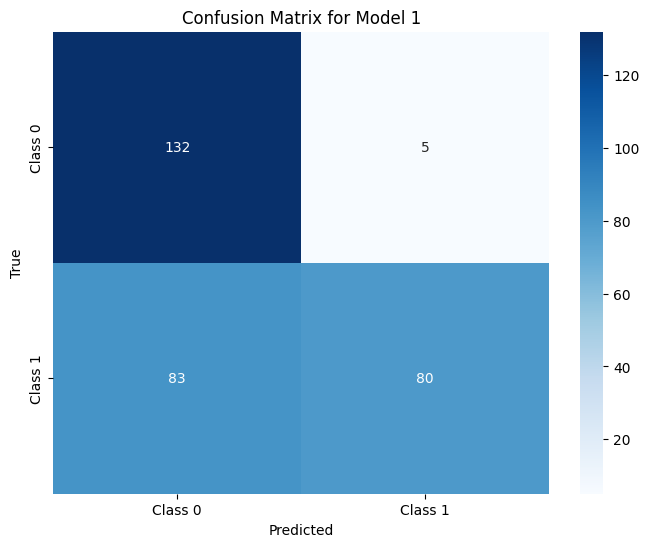

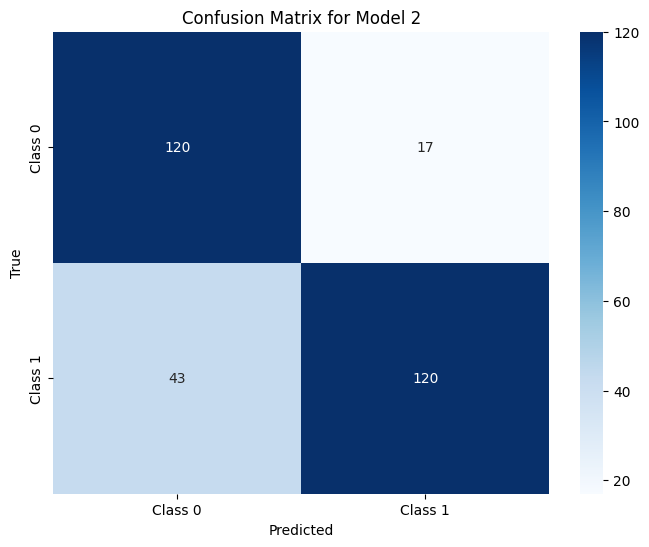

In [ ]:
visualizacion_perdida_precision(all_train_losses, all_train_accuracies, 'Train')
accuracy_results(accuracies)

# Elegir un modelo específico para la matriz de confusión (por ejemplo, el primer modelo)
for i in range(len(all_best_models)):
  plot_confusion_matrix(all_best_models[i], test_loader, i)

## 2.5 Aplicar a ambas redes distintos optimizadores

Epoch 1, Loss: 0.68457211621783, Training Accuracy: 58.57142857142857%
Validation Accuracy: 54.666666666666664%
Epoch 2, Loss: 0.5714974803003398, Training Accuracy: 74.78571428571429%
Validation Accuracy: 70.33333333333333%
Epoch 3, Loss: 0.518354019658132, Training Accuracy: 81.07142857142857%
Validation Accuracy: 75.66666666666667%
Epoch 4, Loss: 0.452659472823143, Training Accuracy: 85.14285714285714%
Validation Accuracy: 77.66666666666667%
Epoch 5, Loss: 0.4160232696343552, Training Accuracy: 88.35714285714286%
Validation Accuracy: 78.66666666666667%
Epoch 6, Loss: 0.3936341035772454, Training Accuracy: 88.28571428571429%
Validation Accuracy: 78.0%
Epoch 7, Loss: 0.3835805051706054, Training Accuracy: 88.21428571428571%
Validation Accuracy: 79.0%
Epoch 8, Loss: 0.28185142136432906, Training Accuracy: 92.35714285714286%
Validation Accuracy: 79.66666666666667%
Epoch 9, Loss: 0.24421881427141753, Training Accuracy: 92.64285714285714%
Validation Accuracy: 79.33333333333333%
Epoch 10, 

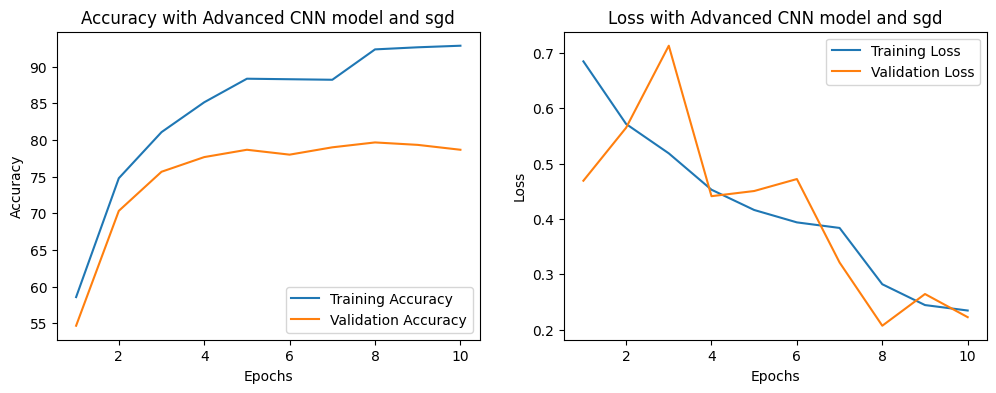

Epoch 1, Loss: 20.131662653251126, Training Accuracy: 52.57142857142857%
Validation Accuracy: 53.0%
Epoch 2, Loss: 0.7947587736628272, Training Accuracy: 67.42857142857143%
Validation Accuracy: 67.0%
Epoch 3, Loss: 0.7541237385435537, Training Accuracy: 53.214285714285715%
Validation Accuracy: 53.333333333333336%
Epoch 4, Loss: 0.7082389444112778, Training Accuracy: 73.57142857142857%
Validation Accuracy: 73.66666666666667%
Epoch 5, Loss: 0.714361999522556, Training Accuracy: 76.42857142857143%
Validation Accuracy: 74.33333333333333%
Epoch 6, Loss: 0.6823008453304117, Training Accuracy: 62.785714285714285%
Validation Accuracy: 62.333333333333336%
Epoch 7, Loss: 0.6806933656334877, Training Accuracy: 77.42857142857143%
Validation Accuracy: 75.0%
Epoch 8, Loss: 0.5240704224190929, Training Accuracy: 82.14285714285714%
Validation Accuracy: 78.66666666666667%
Epoch 9, Loss: 0.48746210404417734, Training Accuracy: 78.71428571428571%
Validation Accuracy: 75.33333333333333%
Epoch 10, Loss: 0.

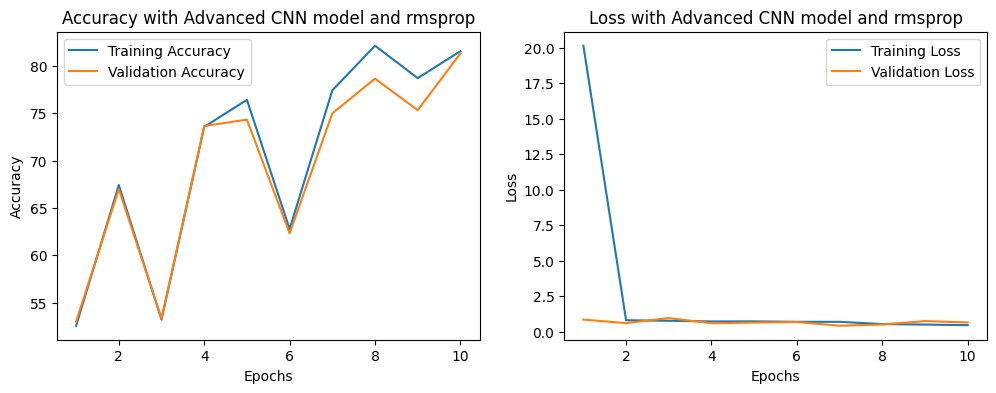

Epoch 1, Loss: 90.68763792650266, Training Accuracy: 58.714285714285715%
Validation Accuracy: 63.0%
Epoch 2, Loss: 0.7170751568945971, Training Accuracy: 52.5%
Validation Accuracy: 55.333333333333336%
Epoch 3, Loss: 0.7081707119941711, Training Accuracy: 52.357142857142854%
Validation Accuracy: 54.0%
Epoch 4, Loss: 0.696309510957111, Training Accuracy: 54.857142857142854%
Validation Accuracy: 55.0%
Epoch 5, Loss: 0.6928665434772318, Training Accuracy: 53.92857142857143%
Validation Accuracy: 55.333333333333336%
Epoch 6, Loss: 0.6908178437839855, Training Accuracy: 52.5%
Validation Accuracy: 52.333333333333336%
Early stopping triggered


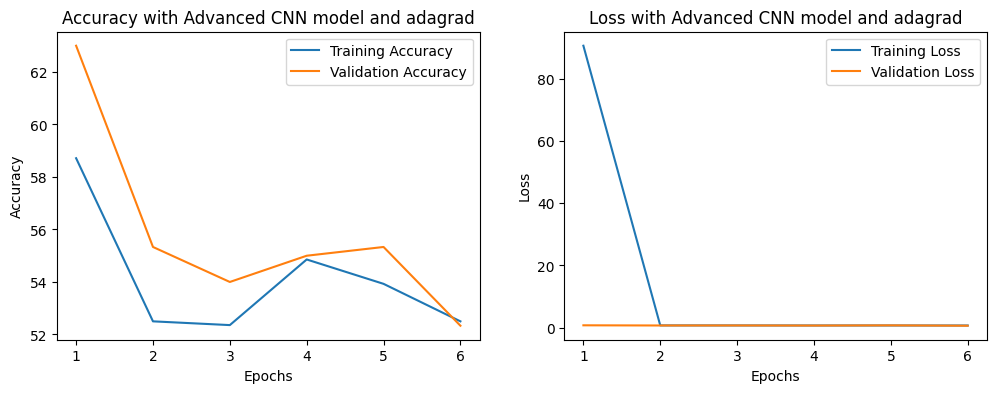

Epoch 1, Loss: 0.6980970014225353, Training Accuracy: 57.142857142857146%
Validation Accuracy: 58.333333333333336%
Epoch 2, Loss: 0.6466005634177815, Training Accuracy: 70.21428571428571%
Validation Accuracy: 69.33333333333333%
Epoch 3, Loss: 0.6172495409846306, Training Accuracy: 71.35714285714286%
Validation Accuracy: 73.66666666666667%
Epoch 4, Loss: 0.5789440822872248, Training Accuracy: 74.85714285714286%
Validation Accuracy: 73.33333333333333%
Epoch 5, Loss: 0.551423038948666, Training Accuracy: 73.92857142857143%
Validation Accuracy: 72.0%
Epoch 6, Loss: 0.5302899425679987, Training Accuracy: 77.14285714285714%
Validation Accuracy: 76.33333333333333%
Epoch 7, Loss: 0.5308536711064252, Training Accuracy: 78.07142857142857%
Validation Accuracy: 77.0%
Epoch 8, Loss: 0.5041631812399084, Training Accuracy: 80.85714285714286%
Validation Accuracy: 80.66666666666667%
Epoch 9, Loss: 0.5055473704229702, Training Accuracy: 81.14285714285714%
Validation Accuracy: 79.33333333333333%
Epoch 10

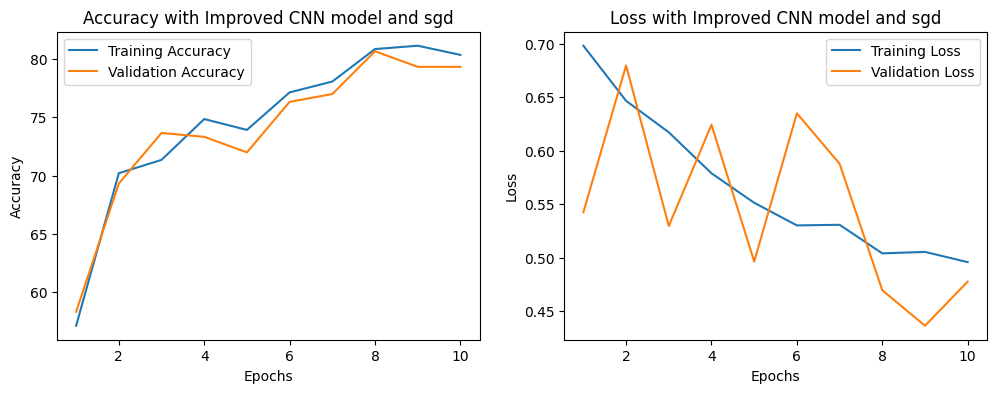

Epoch 1, Loss: 0.6785048998214982, Training Accuracy: 64.0%
Validation Accuracy: 61.666666666666664%
Epoch 2, Loss: 0.6319975636222146, Training Accuracy: 59.714285714285715%
Validation Accuracy: 58.0%
Epoch 3, Loss: 0.5919750278646295, Training Accuracy: 73.85714285714286%
Validation Accuracy: 73.33333333333333%
Epoch 4, Loss: 0.5753648443655535, Training Accuracy: 66.21428571428571%
Validation Accuracy: 66.0%
Epoch 5, Loss: 0.5652215358885851, Training Accuracy: 76.42857142857143%
Validation Accuracy: 76.33333333333333%
Epoch 6, Loss: 0.534764558754184, Training Accuracy: 66.35714285714286%
Validation Accuracy: 67.0%
Epoch 7, Loss: 0.5256085389039733, Training Accuracy: 79.64285714285714%
Validation Accuracy: 78.66666666666667%
Epoch 8, Loss: 0.46621815115213394, Training Accuracy: 83.0%
Validation Accuracy: 81.66666666666667%
Epoch 9, Loss: 0.43412653424523096, Training Accuracy: 83.21428571428571%
Validation Accuracy: 81.66666666666667%
Epoch 10, Loss: 0.4349110725928437, Training 

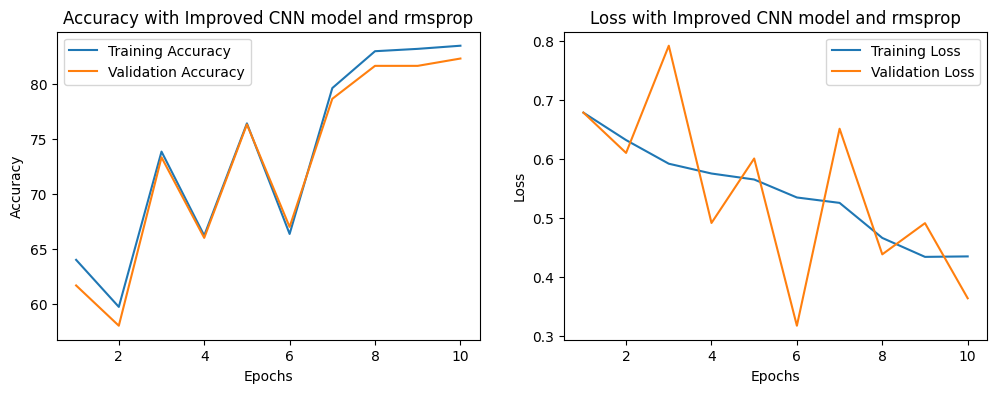

Epoch 1, Loss: 0.6653762486847964, Training Accuracy: 67.42857142857143%
Validation Accuracy: 68.66666666666667%
Epoch 2, Loss: 0.5697579729286107, Training Accuracy: 64.0%
Validation Accuracy: 62.333333333333336%
Epoch 3, Loss: 0.5383935807780786, Training Accuracy: 77.64285714285714%
Validation Accuracy: 76.66666666666667%
Epoch 4, Loss: 0.5190405882894993, Training Accuracy: 78.64285714285714%
Validation Accuracy: 78.0%
Epoch 5, Loss: 0.46469084512103687, Training Accuracy: 78.21428571428571%
Validation Accuracy: 78.0%
Epoch 6, Loss: 0.46486272188750183, Training Accuracy: 83.21428571428571%
Validation Accuracy: 82.33333333333333%
Epoch 7, Loss: 0.43709731237454846, Training Accuracy: 81.64285714285714%
Validation Accuracy: 81.33333333333333%
Epoch 8, Loss: 0.42511260170828213, Training Accuracy: 84.85714285714286%
Validation Accuracy: 83.66666666666667%
Epoch 9, Loss: 0.41410186514258385, Training Accuracy: 85.14285714285714%
Validation Accuracy: 82.66666666666667%
Epoch 10, Loss: 

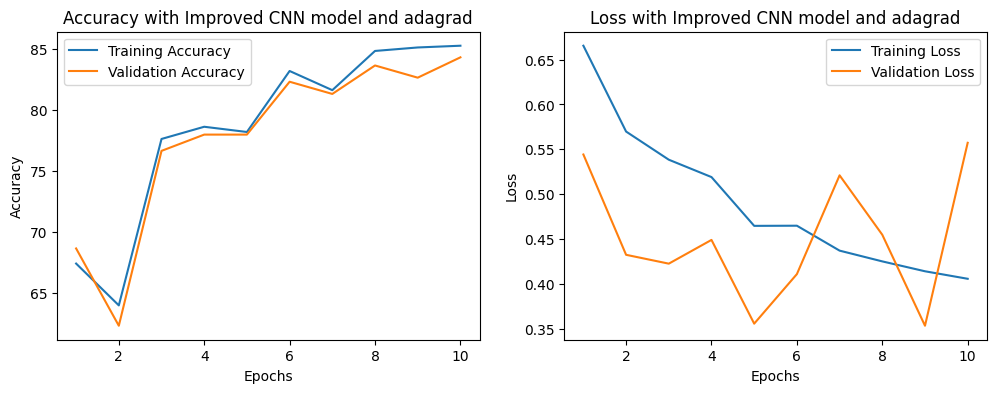

In [ ]:
# Después de modificar la función train_model, puedes usarla para obtener las métricas y luego graficarlas.
# Asegúrate de tener instalada la librería matplotlib antes de ejecutar este código.
import matplotlib.pyplot as plt

# Crear una instancia del modelo (por ejemplo, AdvancedCNN)
models = {AdvancedCNN().to(device):'Advanced CNN model', ImprovedCNN().to(device): 'Improved CNN model'}
optimizers = ['sgd', 'rmsprop', 'adagrad']
for model, model_name in models.items():
    for optimizer in optimizers:
        # Entrenar el modelo con métricas
        trained_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, num_epochs=10, l1_lambda=0.0, l2_lambda=1e-5, optimizer_type=optimizer)
        # Graficar las métricas
        #epochs_range = range(1, len(train_accuracies) + 1)
        plot_results(train_accuracies, val_accuracies, train_losses, val_losses, model_name, optimizer)

## 2.6 Transfer Learning

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 153MB/s]


Training model 1
Epoch 1, Loss: 0.3767624107951468, Training Accuracy: 98.21428571428571%
Validation Accuracy: 94.0%
Epoch 2, Loss: 0.09992415123534473, Training Accuracy: 99.71428571428571%
Validation Accuracy: 95.33333333333333%
Epoch 3, Loss: 0.04375050976787778, Training Accuracy: 99.92857142857143%
Validation Accuracy: 94.33333333333333%
Epoch 4, Loss: 0.01658510296097533, Training Accuracy: 99.92857142857143%
Validation Accuracy: 95.0%
Epoch 5, Loss: 0.00726566000693393, Training Accuracy: 99.92857142857143%
Validation Accuracy: 95.0%
Training model 2
Epoch 1, Loss: 0.42168295485052193, Training Accuracy: 97.92857142857143%
Validation Accuracy: 93.66666666666667%
Epoch 2, Loss: 0.11682572004131296, Training Accuracy: 99.57142857142857%
Validation Accuracy: 94.0%
Epoch 3, Loss: 0.04325719143856655, Training Accuracy: 99.92857142857143%
Validation Accuracy: 96.0%
Epoch 4, Loss: 0.018344896543898027, Training Accuracy: 100.0%
Validation Accuracy: 95.0%
Epoch 5, Loss: 0.0082719199391

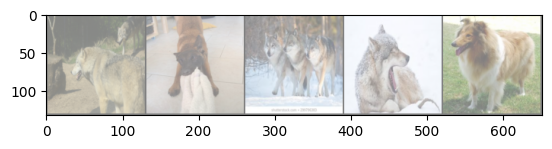

Etiquetas verdaderas:  1 0 1 1 0
Predicciones:  1 0 1 1 0


In [ ]:
import torchvision.models as models
train_data, train_loader, val_loader, test_loader, val_data = load_data()

# Definir una nueva clase que extienda ResNet18, que es una arquitectura preentrenada en un conjunto de datos específico
class TransferLearningCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(TransferLearningCNN, self).__init__()
        resnet18 = models.resnet18(pretrained=True)

        # Utilizar las capas convolucionales de ResNet18
        self.features = nn.Sequential(*list(resnet18.children())[:-2])

        # Agregar capas de clasificación personalizadas
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Crear una instancia del modelo TransferLearningCNN
num_models = 3
models = [TransferLearningCNN().to(device) for _ in range(num_models)]
best_models = []
train_losses_all = []
val_losses_all = []
train_accuracies_all = []
val_accuracies_all = []

for model_idx, model in enumerate(models):
    print(f"Training model {model_idx+1}")
    best_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, num_epochs=5)
    best_models.append(best_model)
    train_losses_all.append(train_losses)
    val_losses_all.append(val_losses)
    train_accuracies_all.append(train_accuracies)
    val_accuracies_all.append(val_accuracies)

full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_loader = DataLoader(full_train_data, batch_size=32, shuffle=True)

all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_best_models = []

for model_idx, model in enumerate(best_models):
    print(f"Re-training model {model_idx+1} with full train data")
    model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, full_train_loader, None, num_epochs=5)
    torch.save(model.state_dict(), f'final_model_{model_idx+1}.pth')
    all_best_models.append(model)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

accuracies = []
for model_idx, model in enumerate(best_models):
    model.load_state_dict(torch.load(f'final_model_{model_idx+1}.pth'))
    test_accuracy = calculate_accuracy(model, test_loader)
    accuracies.append(test_accuracy)
    print(f"Final Test Accuracy for model {model_idx+1}: {test_accuracy}%")

ensemble_test_accuracy = evaluate_ensemble(best_models, test_loader)
print(f"Ensemble Test Accuracy: {ensemble_test_accuracy}%")

visualize_predictions(best_models[0], test_loader)

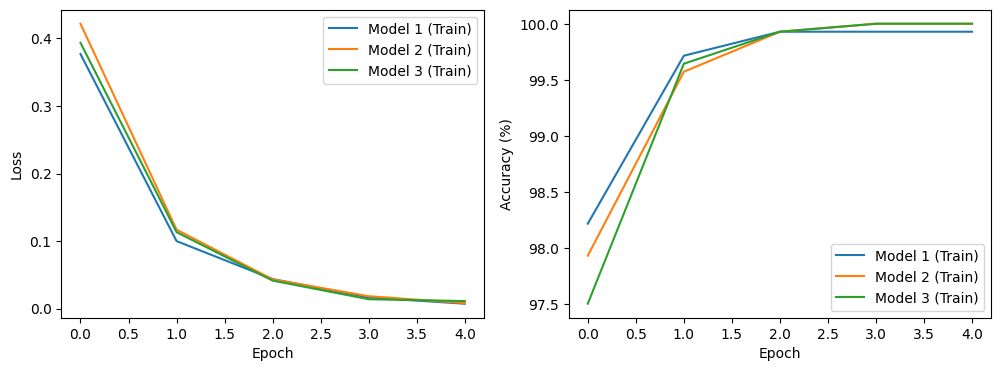

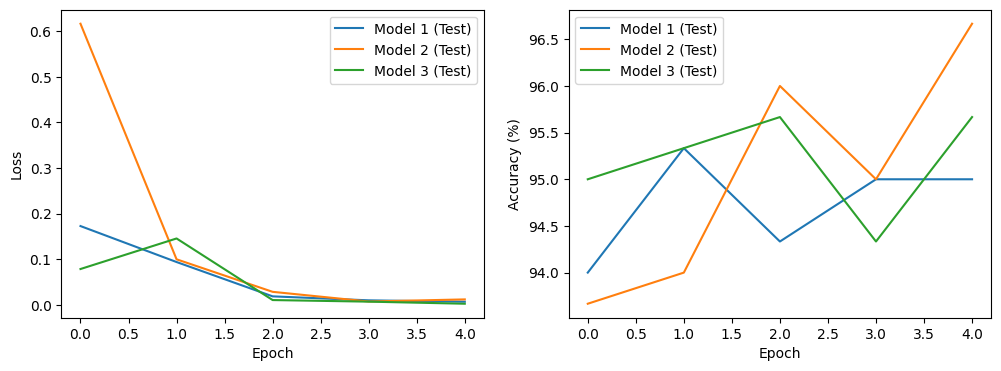

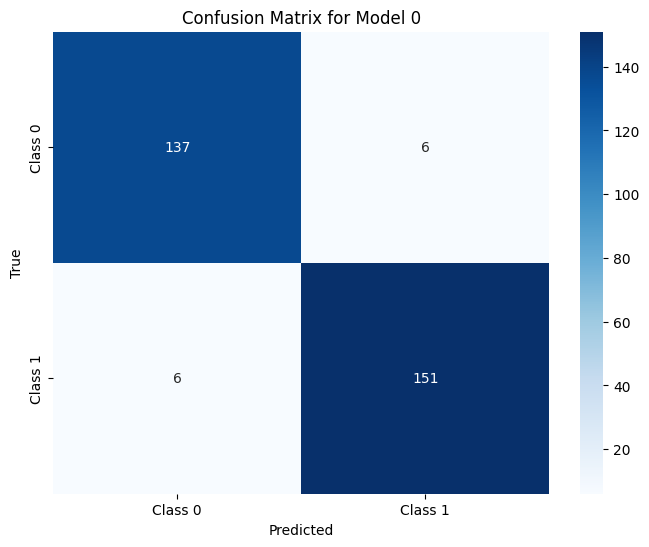

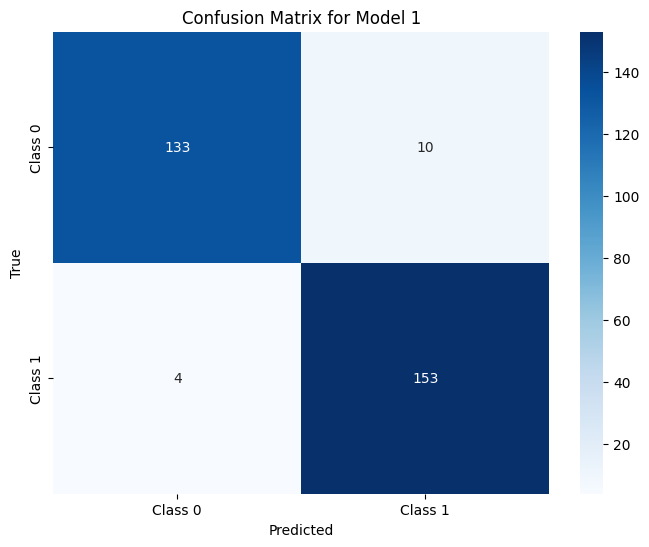

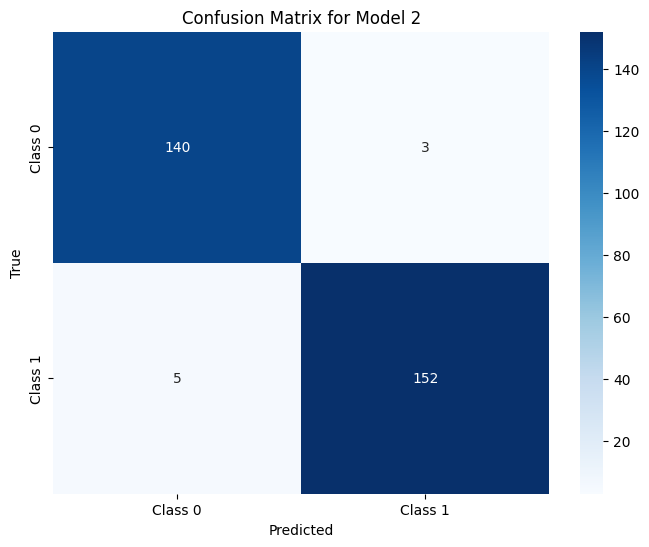

In [ ]:
visualizacion_perdida_precision(train_losses_all, train_accuracies_all, 'Train')
# Suponiendo que val_losses_all y val_accuracies_all son listas de listas con tensores en GPU
val_losses_all_cpu = [[tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in sublist] for sublist in val_losses_all]
val_accuracies_all_cpu = [[tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in sublist] for sublist in val_accuracies_all]

visualizacion_perdida_precision(val_losses_all_cpu, val_accuracies_all_cpu, 'Test')

# Elegir un modelo específico para la matriz de confusión (por ejemplo, el primer modelo)
for i in range(len(best_models)):
  plot_confusion_matrix(best_models[i], test_loader, i)

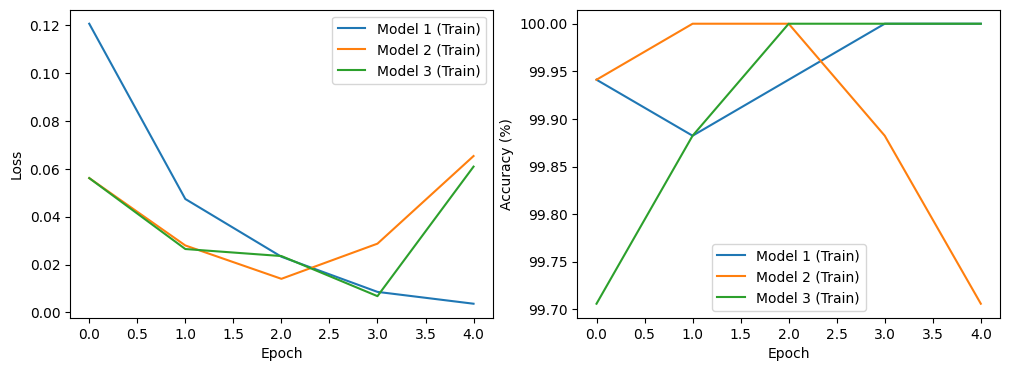

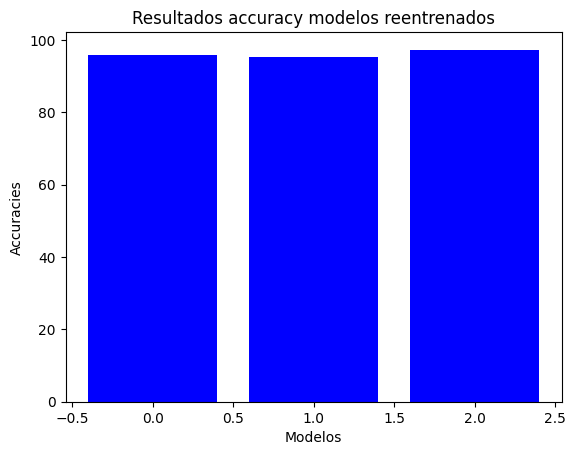

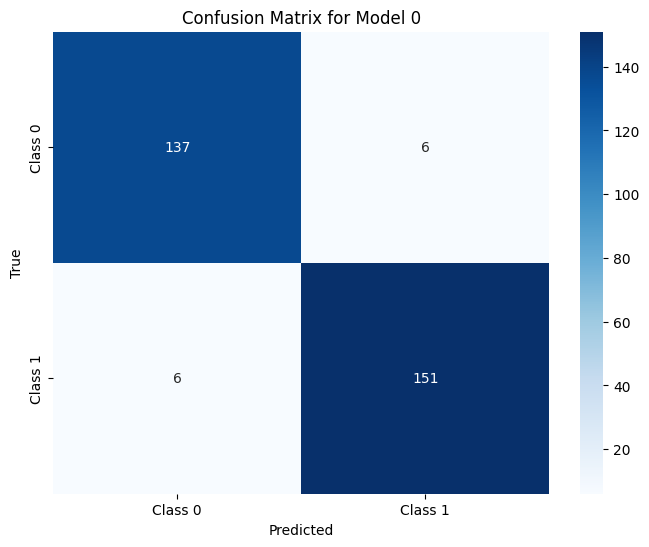

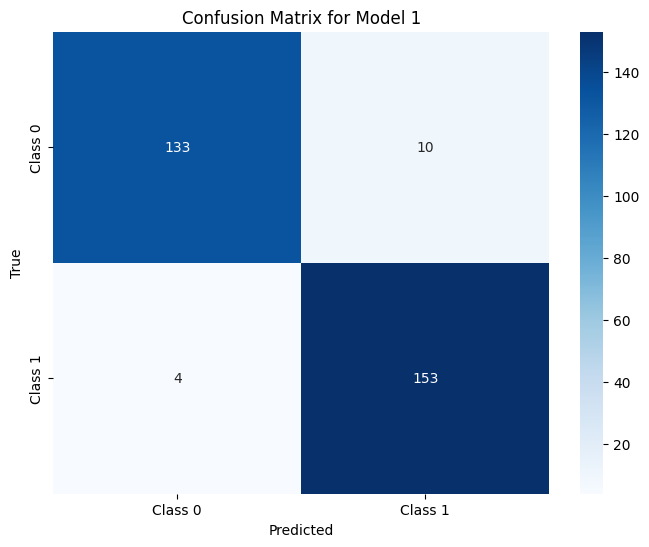

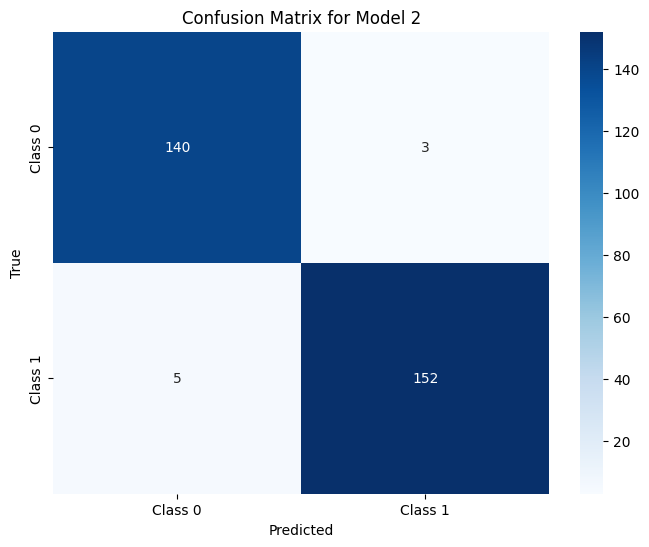

In [ ]:
visualizacion_perdida_precision(all_train_losses, all_train_accuracies, 'Train')
accuracy_results(accuracies)

# Elegir un modelo específico para la matriz de confusión (por ejemplo, el primer modelo)
for i in range(len(all_best_models)):
  plot_confusion_matrix(all_best_models[i], test_loader, i)

## 2.7 Segundo conjunto de datos


In [19]:
DATASET_2 = os.path.join('/content/drive/My Drive/AA2/datasets', 'data_2') # esto puede cambiar dependiendo de donde se ejecute el notebook
INITIAL_SIZE_OF_IMAGES = (128, 128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
data_transforms = transforms.Compose([
    transforms.Resize(INITIAL_SIZE_OF_IMAGES),
    transforms.ToTensor()
])

train_dataset_2 = datasets.ImageFolder(root=DATASET_2, transform=data_transforms)
train_loader_2 = DataLoader(train_dataset_2, batch_size=32, shuffle=True)

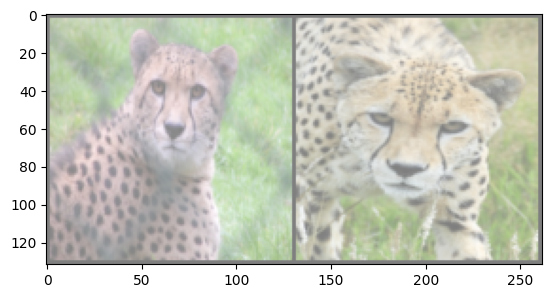

In [21]:
# Obtiene un batch de imagenes
dataiter_2 = iter(train_loader_2)
images_2, labels_2 = next(dataiter_2)

def imshow_2(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Mostramos las imagenes
imshow_2(vutils.make_grid(images_2[1:3], normalize=True))


In [22]:
train_size_2 = int(0.7 * len(train_dataset_2))
remaining_2 = len(train_dataset_2) - train_size_2
val_size_2 = int(0.5 * remaining_2)
test_size_2 = remaining_2 - val_size_2

train_data_2, remaining_data_2 = random_split(train_dataset_2, [train_size_2, remaining_2])
val_data_2, test_data_2 = random_split(remaining_data_2, [val_size_2, test_size_2])

# DataLoaders para el segundo conjunto de datos
train_loader_2 = DataLoader(train_data_2, batch_size=32, shuffle=True)
val_loader_2 = DataLoader(val_data_2, batch_size=32, shuffle=False)
test_loader_2 = DataLoader(test_data_2, batch_size=32, shuffle=False)
print(len(test_loader_2))

9


In [28]:
def load_data_2():
    train_dataset_2 = datasets.ImageFolder(root=DATASET_2, transform=data_transforms)  # Utiliza el nuevo directorio DATASET_2
    train_loader_2 = DataLoader(train_dataset_2, batch_size=32, shuffle=True)
    train_size_2 = int(0.7 * len(train_dataset_2))  # 70% para entrenamiento
    remaining_2 = len(train_dataset_2) - train_size_2
    val_size_2 = int(0.5 * remaining_2)  # 15% para validación
    test_size_2 = remaining_2 - val_size_2  # 15% para prueba

    train_data_2, remaining_data_2 = random_split(train_dataset_2, [train_size_2, remaining_2])
    val_data_2, test_data_2 = random_split(remaining_data_2, [val_size_2, test_size_2])

    # DataLoaders para el segundo conjunto de datos
    train_loader_2 = DataLoader(train_data_2, batch_size=32, shuffle=True)
    val_loader_2 = DataLoader(val_data_2, batch_size=32, shuffle=False)
    test_loader_2 = DataLoader(test_data_2, batch_size=32, shuffle=False)

    return train_data_2, train_loader_2, val_loader_2, test_loader_2, val_data_2


def calculate_accuracy(model, data_loader):
    model.eval()  # Poner el modelo en modo evaluación
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Función para entrenar el modelo
def train_model_2(model, train_loader_2, val_loader_2=None, num_epochs=10, l1_lambda=0.0, l2_lambda=0.0, optimizer_type='adam'):
    criterion = nn.CrossEntropyLoss()

    # Añadir regularización L2 al optimizador
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=l2_lambda)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=l2_lambda)
    elif optimizer_type == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9, weight_decay=l2_lambda)
    elif optimizer_type == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=0.01, weight_decay=l2_lambda)
    else:
        raise ValueError(f"Optimizador no reconocido: {optimizer_type}")
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    best_val_acc_2 = 0.0
    early_stopping_counter_2 = 0
    patience_2 = 5
    best_model_wts_2 = None

    train_losses_2 = []
    val_losses_2 = []
    train_accuracies_2 = []
    val_accuracies_2 = []

    for epoch in range(num_epochs):
        model.train()  # Poner el modelo en modo de entrenamiento
        running_loss_2 = 0.0
        for i, data in enumerate(train_loader_2, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            running_loss_2 += loss.item()

        train_acc_2 = calculate_accuracy(model, train_loader_2)
        print(f"Epoch {epoch+1}, Loss: {running_loss_2/len(train_loader_2)}, Training Accuracy: {train_acc_2}%")
        wandb.log({"Train Accuracy": train_acc_2, "Train Loss": running_loss_2/len(train_loader_2), "Epoch": epoch})

        # Si tenemos un val_loader, calcular la precisión de validación
        if val_loader_2 is not None:
            val_acc_2 = calculate_accuracy(model, val_loader_2)
            print(f"Validation Accuracy: {val_acc_2}%")
            wandb.log({"Validation Accuracy": val_acc_2, "Epoch": epoch})

            # Early stopping y guardar el mejor modelo
            if val_acc_2 > best_val_acc_2:
                best_val_acc_2 = val_acc_2
                early_stopping_counter_2 = 0
                best_model_wts_2 = model.state_dict().copy()  # Guardar los mejores pesos del modelo
            else:
                early_stopping_counter_2 += 1
                if early_stopping_counter_2 >= patience_2:
                    print("Early stopping triggered")
                    break

        scheduler.step()

    # Si se encontró un mejor conjunto de pesos, cargarlos
    if best_model_wts_2 is not None:
        model.load_state_dict(best_model_wts_2)

    return model, train_losses_2, val_losses_2, train_accuracies_2, val_accuracies_2

# Función para evaluar el ensemble en el conjunto de prueba
def evaluate_ensemble_2(models_2, data_loader_2):
    # Colocamos todos los modelos en modo de evaluación
    for model in models_2:
        model.eval()

    total_predictions_2 = torch.tensor([]).to(device)
    total_true_labels_2 = torch.tensor([]).to(device)

    with torch.no_grad():
        for inputs, labels in data_loader_2:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Obtenemos las predicciones de todos los modelos
            predictions = [model(inputs) for model in models_2]
            # Calculamos el promedio de las predicciones
            avg_predictions = torch.mean(torch.stack(predictions), dim=0)
            _, ensemble_predicted_2 = torch.max(avg_predictions, 1)

            # Acumulamos las predicciones y las verdaderas etiquetas
            total_predictions_2 = torch.cat((total_predictions_2, ensemble_predicted_2))
            total_true_labels_2 = torch.cat((total_true_labels_2, labels))

    # Calculamos la precisión del ensemble
    ensemble_accuracy_2 = accuracy_score(total_true_labels_2.cpu(), total_predictions_2.cpu())
    return ensemble_accuracy_2

# Visualización de la pérdida y precisión
def visualize_predictions_2(model, data_loader_2, num_images=5):
    dataiter_2 = iter(data_loader_2)
    images_2, labels_2 = next(dataiter_2)

    # Mostrar imágenes
    imshow_2(torchvision.utils.make_grid(images_2[:num_images]))
    images_2 = images_2.to(device)

    # Obtener predicciones
    outputs_2 = model(images_2)
    _, predicted_2 = torch.max(outputs_2, 1)

    # Imprimir etiquetas verdaderas y predichas
    print('Etiquetas verdaderas: ', ' '.join(f'{labels_2[j]}' for j in range(num_images)))
    print('Predicciones: ', ' '.join(f'{predicted_2[j]}' for j in range(num_images)))

def visualizacion_perdida_precision_2(train_losses, train_accuracies, val_losses, val_accuracies, settype):
    # Crear figuras de Matplotlib
    fig_loss, ax_loss = plt.subplots()
    fig_accuracy, ax_accuracy = plt.subplots()

    # Plotear pérdida y precisión para el conjunto de entrenamiento
    ax_loss.plot(range(len(train_losses)), train_losses, label=f'Model {model_idx+1} ({settype})')
    ax_accuracy.plot(range(len(train_accuracies)), train_accuracies, label=f'Model {model_idx+1} ({settype})')

    # Registrar pérdida y precisión en WandB para el conjunto de entrenamiento
    wandb.log({f'{settype} Loss Model {model_idx+1}': train_losses})
    wandb.log({f'{settype} Accuracy Model {model_idx+1}': train_accuracies})

    # Plotear pérdida y precisión para el conjunto de validación
    ax_loss.plot(range(len(val_losses)), val_losses, label=f'Model {model_idx+1} ({settype})')
    ax_accuracy.plot(range(len(val_accuracies)), val_accuracies, label=f'Model {model_idx+1} ({settype})')

    # Registrar pérdida y precisión en WandB para el conjunto de validación
    wandb.log({f'{settype} Loss Model {model_idx+1}': val_losses})
    wandb.log({f'{settype} Accuracy Model {model_idx+1}': val_accuracies})

    # Ajustar etiquetas y leyenda para las gráficas
    ax_loss.set(xlabel='Epoch', ylabel='Loss')
    ax_loss.legend()
    fig_loss.suptitle(f'{settype} Loss ({settype})')

    ax_accuracy.set(xlabel='Epoch', ylabel='Accuracy')
    ax_accuracy.legend()
    fig_accuracy.suptitle(f'{settype} Accuracy ({settype})')

    # Cerrar las figuras para evitar que se muestren automáticamente en el notebook
    plt.close(fig_loss)
    plt.close(fig_accuracy)



#### 2.7.1 AdvancedCNN usando wandb

<img src="http://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />
<!--- @wandbcode{intro-colab} -->

In [12]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [13]:
import wandb
import plotly.express as px

wandb.init(project="AA2", name="segundo_dataset")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Training model 1
Epoch 1, Loss: 0.7365919776260853, Training Accuracy: 50.35685963521015%
Validation Accuracy: 52.96296296296296%
Epoch 2, Loss: 0.4606406696140766, Training Accuracy: 73.35448057097541%
Validation Accuracy: 73.70370370370371%
Epoch 3, Loss: 0.41253053247928617, Training Accuracy: 83.98096748612213%
Validation Accuracy: 83.33333333333333%
Epoch 4, Loss: 0.3281480144709349, Training Accuracy: 79.85725614591594%
Validation Accuracy: 77.77777777777777%
Epoch 5, Loss: 0.3056545052677393, Training Accuracy: 88.58049167327518%
Validation Accuracy: 84.44444444444444%
Epoch 6, Loss: 0.24340498112142087, Training Accuracy: 87.78747026169707%
Validation Accuracy: 83.70370370370371%
Epoch 7, Loss: 0.22688451670110227, Training Accuracy: 95.32117367168914%
Validation Accuracy: 92.22222222222223%
Epoch 8, Loss: 0.1356160177383572, Training Accuracy: 96.90721649484536%
Validation Accuracy: 92.22222222222223%
Epoch 9, Loss: 0.11766268704086542, Training Accuracy: 97.30372720063441%
Va

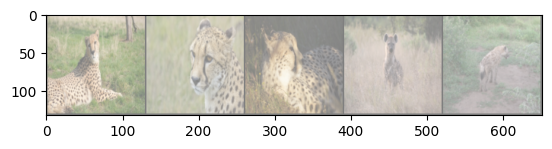

Etiquetas verdaderas:  0 0 0 1 1
Predicciones:  0 0 0 1 1


In [29]:
torch.manual_seed(0)

num_models_2 = 3
models_2 = [AdvancedCNN().to(device) for _ in range(num_models_2)]
best_models_2 = []
train_losses_all_2 = []
val_losses_all_2 = []
train_accuracies_all_2 = []
val_accuracies_all_2 = []

for model_idx, model in enumerate(models_2):
    print(f"Training model {model_idx+1}")
    best_model_2, train_losses_2, val_losses_2, train_accuracies_2, val_accuracies_2 = train_model_2(model, train_loader_2, val_loader_2, num_epochs=10)
    torch.save(best_model_2.state_dict(), f'model_{model_idx+1}.pth')
    wandb.save(f'model_{model_idx+1}.pth')

    best_models_2.append(best_model_2)
    train_losses_all_2.append(train_losses_2)
    val_losses_all_2.append(val_losses_2)
    train_accuracies_all_2.append(train_accuracies_2)
    val_accuracies_all_2.append(val_accuracies_2)

full_train_data_2 = torch.utils.data.ConcatDataset([train_data_2, val_data_2])
full_train_loader_2 = DataLoader(full_train_data_2, batch_size=32, shuffle=True)

all_train_losses_2 = []
all_val_losses_2 = []
all_train_accuracies_2 = []
all_val_accuracies_2 = []
all_best_models_2 = []

for model_idx, model in enumerate(best_models_2):
    print(f"Re-training model {model_idx+1} with full train data")
    model, train_losses_2, val_losses_2, train_accuracies_2, val_accuracies_2 = train_model_2(model, full_train_loader_2, None, num_epochs=5)

    torch.save(model.state_dict(), f'final_model_2_{model_idx+1}.pth')
    wandb.save(f'final_model_2_{model_idx+1}.pth')
    all_best_models_2.append(model)
    all_train_losses_2.append(train_losses_2)
    all_val_losses_2.append(val_losses_2)
    all_train_accuracies_2.append(train_accuracies_2)
    all_val_accuracies_2.append(val_accuracies_2)

accuracies_2 = []
for model_idx, model in enumerate(best_models_2):
    model.load_state_dict(torch.load(f'final_model_2_{model_idx+1}.pth'))
    test_accuracy_2 = calculate_accuracy(model, test_loader_2)
    accuracies_2.append(test_accuracy_2)
    print(f"Final Test Accuracy for model {model_idx+1}: {test_accuracy_2}%")
    wandb.log({"Final Test Accuracy for model": test_accuracy_2, "Model": model_idx+1})

ensemble_test_accuracy_2 = evaluate_ensemble_2(best_models_2, test_loader_2)
print(f"Ensemble Test Accuracy: {ensemble_test_accuracy_2}%")
wandb.log({"Ensemble Test Accuracy": ensemble_test_accuracy_2})

visualize_predictions_2(best_models_2[0], test_loader_2)

In [30]:
# Elegir un modelo específico para la matriz de confusión (por ejemplo, el primer modelo)
for model_idx, model in enumerate(best_models_2):
    run = wandb.init(project="confusion-matrices", name=f"model-{model_idx+1}")

    # Realizar predicciones en el conjunto de prueba
    predictions = []
    true_labels = []
    for images, labels in test_loader_2:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    # Calcular la matriz de confusión
    cm = confusion_matrix(true_labels, predictions)

    # Crear y registrar la matriz de confusión con plotly
    fig = px.imshow(cm, labels=dict(x="Predicted", y="True", color="Count"), color_continuous_scale='viridis')
    wandb.log({"Confusion Matrix": fig})

    # Cerrar la ejecución de wandb para este modelo
    run.finish()

# Cerrar la ejecución de wandb (fuera del bucle)
wandb.finish()

Ensemble Test Accuracy,▁
Epoch,▁▂▃▅▆▇▁▂▃▅▆▇▁▃▃▅▆▇▁▃▃▅▆▇▁▃▄▅▆█▁▃▄▅▆█▂▁▄▃
Final Test Accuracy for model,█▆▄▅▁▅
Model,▁▅█▁▅█
Train Accuracy,▂▆▅▇██▅▅▇██▁▅▇▇█▁▆▇███▅▇▇██▆▇▇▇██████▇▇▇
Train Loss,█▅▄▂▁▁▅▄▂▁▁█▄▃▂▁█▅▃▃▂▁▅▃▂▂▁▅▃▃▂▁▂▂▁▂▁▂▁▁
Validation Accuracy,▂▆▅▇▇▇█▁▆▄▇▇█▇▆▅▇▇██▁▄▅▆▇▇█▁▇▇▆▇▇▇▆▆▇▇██
Ensemble Test Accuracy,0.95203
Epoch,4
Final Test Accuracy for model,93.35793
Model,3


wandb: Currently logged in as: sonrisatomorrow (andreamgm). Use `wandb login --relogin` to force relogin


In [31]:
for model_idx, model in enumerate(models_2):
    # Iniciar una nueva ejecución para cada modelo
    run = wandb.init(project="loss-accuracy", name=f"model-{model_idx+1}")

    best_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model_2(model, train_loader_2, val_loader_2, num_epochs=10)

    # Visualizar métricas para el conjunto de entrenamiento y validación
    visualizacion_perdida_precision_2(train_losses, train_accuracies, val_losses, val_accuracies, "Train")

    # Cerrar la ejecución de wandb para este modelo
    run.finish()

# Cerrar la ejecución de wandb (fuera del bucle)
wandb.finish()

Epoch 1, Loss: 0.09770401489804499, Training Accuracy: 97.9381443298969%
Validation Accuracy: 97.03703703703704%
Epoch 2, Loss: 0.08451331174583174, Training Accuracy: 97.9381443298969%
Validation Accuracy: 95.55555555555556%
Epoch 3, Loss: 0.08365006613894366, Training Accuracy: 95.32117367168914%
Validation Accuracy: 93.70370370370371%
Epoch 4, Loss: 0.03701497839065269, Training Accuracy: 99.20697858842189%
Validation Accuracy: 98.51851851851852%
Epoch 5, Loss: 0.02910366292053368, Training Accuracy: 96.43140364789849%
Validation Accuracy: 92.96296296296296%
Epoch 6, Loss: 0.040170589889748955, Training Accuracy: 100.0%
Validation Accuracy: 97.77777777777777%
Epoch 7, Loss: 0.03468173468427267, Training Accuracy: 99.20697858842189%
Validation Accuracy: 97.77777777777777%
Epoch 8, Loss: 0.015520892036147416, Training Accuracy: 99.92069785884219%
Validation Accuracy: 98.88888888888889%
Epoch 9, Loss: 0.01835982642805902, Training Accuracy: 99.92069785884219%
Validation Accuracy: 98.88

Epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
Train Accuracy,▅▅▁▇▃█▇███
Train Loss,█▇▇▃▂▃▃▁▂▁
Validation Accuracy,▆▄▂█▁▇▇███
Epoch,9
Train Accuracy,100.0
Train Loss,0.01081
Validation Accuracy,98.51852


Epoch 1, Loss: 0.1263546123460401, Training Accuracy: 98.81046788263284%
Validation Accuracy: 96.66666666666667%
Epoch 2, Loss: 0.07195971396868117, Training Accuracy: 98.09674861221254%
Validation Accuracy: 97.4074074074074%
Epoch 3, Loss: 0.0513043906117673, Training Accuracy: 99.68279143536876%
Validation Accuracy: 99.25925925925925%
Epoch 4, Loss: 0.06706446880561998, Training Accuracy: 99.60348929421095%
Validation Accuracy: 97.4074074074074%
Epoch 5, Loss: 0.0326635100907879, Training Accuracy: 98.73116574147502%
Validation Accuracy: 95.55555555555556%
Epoch 6, Loss: 0.018838106279144996, Training Accuracy: 99.12767644726408%
Validation Accuracy: 97.4074074074074%
Epoch 7, Loss: 0.03196848426050565, Training Accuracy: 97.70023790642347%
Validation Accuracy: 93.33333333333333%
Epoch 8, Loss: 0.02287210422946373, Training Accuracy: 100.0%
Validation Accuracy: 98.51851851851852%
Early stopping triggered


Epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
Train Accuracy,▄▂▇▇▄▅▁█
Train Loss,█▄▃▄▂▁▂▁
Validation Accuracy,▅▆█▆▄▆▁▇
Epoch,7
Train Accuracy,100.0
Train Loss,0.02287
Validation Accuracy,98.51852


Epoch 1, Loss: 0.1075642547919415, Training Accuracy: 97.85884218873909%
Validation Accuracy: 96.29629629629629%
Epoch 2, Loss: 0.09354814810794779, Training Accuracy: 96.5107057890563%
Validation Accuracy: 95.55555555555556%
Epoch 3, Loss: 0.05773676759272348, Training Accuracy: 95.55908009516257%
Validation Accuracy: 95.55555555555556%
Epoch 4, Loss: 0.04325805227854289, Training Accuracy: 92.62490087232355%
Validation Accuracy: 93.33333333333333%
Epoch 5, Loss: 0.0520485564309638, Training Accuracy: 96.27279936558287%
Validation Accuracy: 95.92592592592592%
Epoch 6, Loss: 0.030998731599538587, Training Accuracy: 99.44488501189532%
Validation Accuracy: 98.14814814814815%
Epoch 7, Loss: 0.015866498265677365, Training Accuracy: 98.49325931800159%
Validation Accuracy: 96.29629629629629%
Epoch 8, Loss: 0.01311548950161523, Training Accuracy: 100.0%
Validation Accuracy: 97.4074074074074%
Epoch 9, Loss: 0.00963529738037323, Training Accuracy: 99.92069785884219%
Validation Accuracy: 98.1481

Epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
Train Accuracy,▆▅▄▁▄▇▇███
Train Loss,█▇▅▄▄▃▂▁▁▁
Validation Accuracy,▅▄▄▁▅█▅▇██
Epoch,9
Train Accuracy,100.0
Train Loss,0.00595
Validation Accuracy,98.51852
